# 1  Supervised Machine Learning for Click Fraud Detection<br>[Companion Workbook]

MLND Capstone Project<br>
Shan Dou<br>
July 2018

## Summary
This jupyter notebook (`MLNDcapstone_shandou_robustness.ipynb`) is a companion of the main workbook. The workflow is identical to the main workbook, but the datasize is doubled. The main objective here is to test the robustness of the modeling pipeline with a larger data volume.

In [1]:
# Notebook settings

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Imports

import os
import subprocess
import warnings
warnings.simplefilter("ignore")
from cycler import cycler
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
linecolors = sns.color_palette('Set1')
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from mlens.ensemble import SuperLearner
import xgboost as xgb
import lightgbm as lgb

%reload_ext autoreload
%autoreload 2
import preprocessing
import modeling
import utils

plt.style.use('./stylelib/custom.mplstyle')

/Users/shandou/anaconda3/envs/mlnd_clean/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
[MLENS] backend: threading


In [4]:
dir_data = './data'
from_scratch = False

# When from_scratch = True, generate randomly sampled subset
csv_train_raw = os.path.join(dir_data, 'train.csv')
csv_train = os.path.join(dir_data, 'train_sample_2.csv')
# Double the data size up to 0.2% of raw records
if from_scratch:
    nlines_raw, nlines_reduced = preprocessing.csv_randomized_downsamp(
        csv_in=csv_train_raw, csv_out=csv_train, fraction=0.002
    )

In [5]:
# Extract field names from training and testing data
dir_data = './data'
csv_train = os.path.join(dir_data, 'train_sample_2.csv')
fields_train = preprocessing.csv_list_fields(csv_in=csv_train)
csv_test = os.path.join(dir_data, 'test.csv')
fields_test = preprocessing.csv_list_fields(csv_in=csv_test)

# Extract fields shared by both training and testing data
fields_keep = list(set(fields_train) & (set(fields_test)))
print('Data fields shared by both training and testing data:\n', fields_keep)

Data fields shared by both training and testing data:
 ['os', 'channel', 'click_time', 'device', 'ip', 'app']


In [6]:
# Load randomly sampled data subset into pandas dataframe,
# and sort by click time (and reset index)
df = pd.read_csv(
    csv_train, usecols=fields_keep + ['is_attributed'],
    parse_dates=['click_time']
).sort_values(by='click_time').reset_index(drop=True)

# Convert click time from UTC to local time
df['click_time'] = (
    pd.DatetimeIndex(df['click_time']).tz_localize('utc')
    .tz_convert('Asia/Shanghai')
)

In [7]:
# 1. Extract hour of the day
df['click_hour'] = df['click_time'].dt.hour

# 2. Drop raw `click_time`
df.drop(columns=['click_time'], inplace=True)

In [8]:
# Split the original dataframe into in-sample training and testing sets
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

# Double check class ratios after train-test split
print(
    'Training data (pos%):',
    100 * df_train['is_attributed'].sum() / len(df_train)
)
print(
    'Testing data (pos%):',
    100 * df_test['is_attributed'].sum() / len(df_test)
)

Training data (pos%): 0.2437573397614191
Testing data (pos%): 0.23615730600398402


In [9]:
# Count the amount of unique values
df_counts = pd.DataFrame()
df_counts['n_unique'] = df_train.nunique()
df_counts['n_unique (%)'] = 100 * df_counts['n_unique'] / len(df_train)
df_counts.T

,ip,app,device,os,channel,is_attributed,click_hour
n_unique,52320.000000,207.000000,175.000000,162.000000,167.000000,2.000000,24.000000
n_unique (%),20.211385,0.079965,0.067603,0.062581,0.064513,0.000773,0.009271


In [10]:
feature_list = [x for x in df_train.columns if x != 'is_attributed']

# 1. Rare label imputation
df_train, df_test = preprocessing.df_rarelabel_imputer(
    df_train, df_test, cols=feature_list, thresh_percentage=0.05
)

# 2. Categorical label encoding
df_train, df_test = preprocessing.df_label2num_encoding(
    df_train, df_test, cols=feature_list
)

In [11]:
target_col = 'is_attributed'
feature_cols = [x for x in df_train.columns if x != target_col]
print('List of features being used:\n', feature_cols)

X_train, y_train = preprocessing.df_to_Xy(
    df_train, target_col=target_col, feature_cols=feature_cols
)
X_test, y_test = preprocessing.df_to_Xy(
    df_test, target_col=target_col, feature_cols=feature_cols
)

List of features being used:
 ['risk_ip', 'count_ip', 'risk_app', 'count_app', 'risk_device', 'count_device', 'risk_os', 'count_os', 'risk_channel', 'count_channel', 'risk_click_hour', 'count_click_hour']


In [12]:
# Initialize book keeping for ROC curve, precision-recall curve,
# confusion matrixes, and feature importance ranking
model_list = ([
    'LogisticRegression', 'RandomForest', 'StackEnsemble',
    'XGBoost', 'LightGBM'
])
roc_val = dict.fromkeys(model_list)
prec_recall_val = dict.fromkeys(model_list)
confmat = dict.fromkeys(model_list)
ft_importance = dict.fromkeys(model_list)

logisticregression
fit runtime = 4.35 s


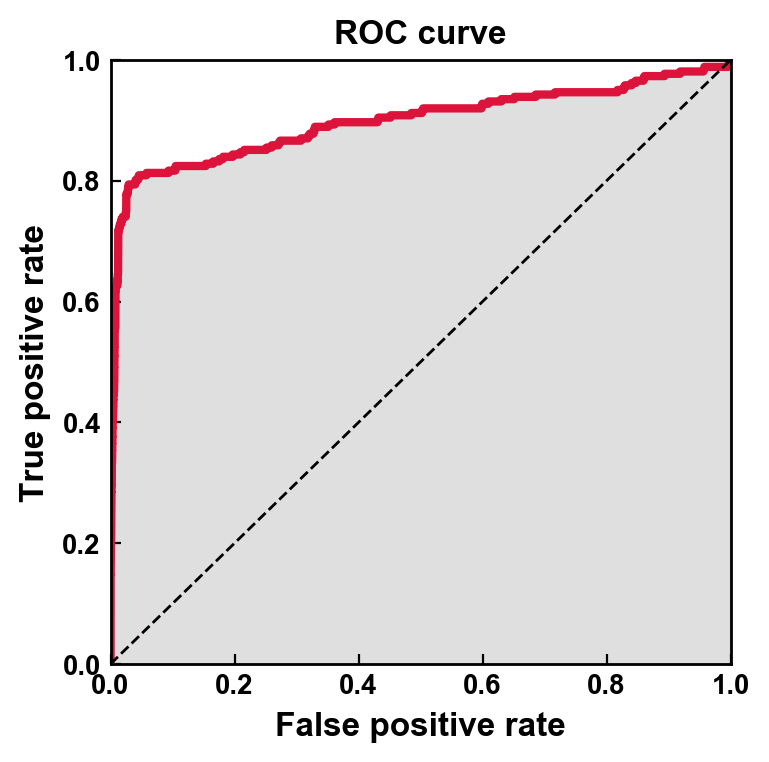

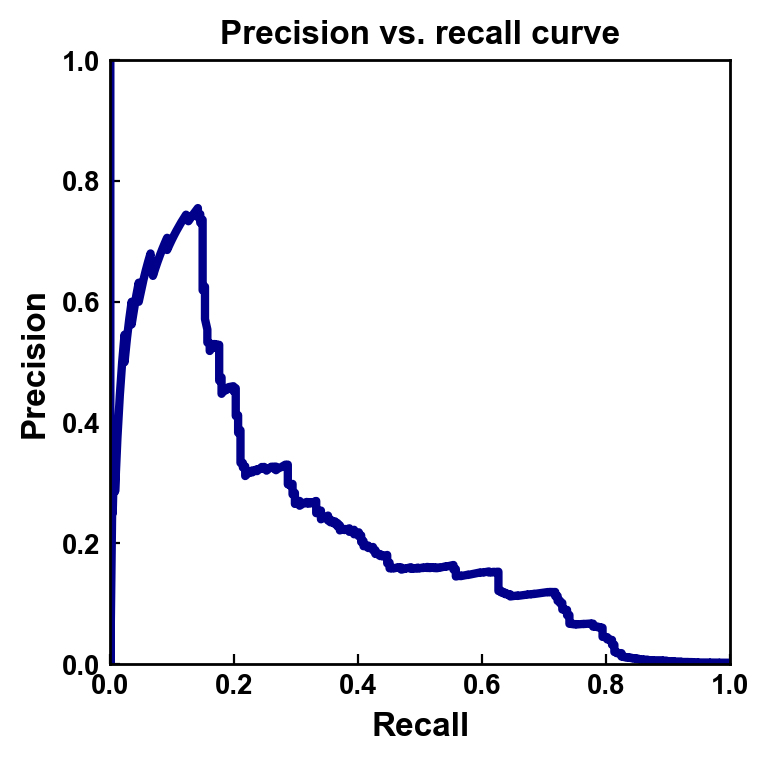

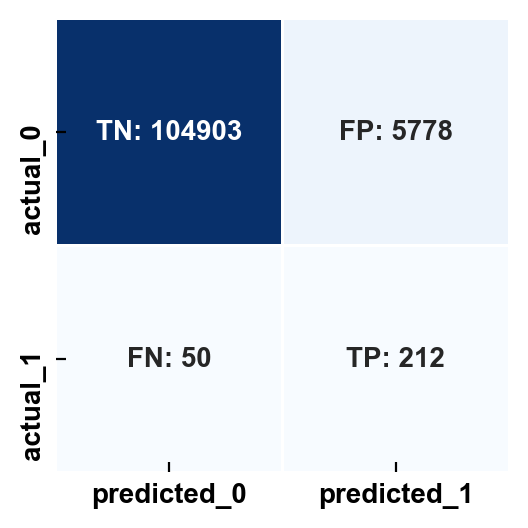

,model,auc_train,auc_cv_std,auc_test
0,LogisticRegression,0.945,0.015,0.878


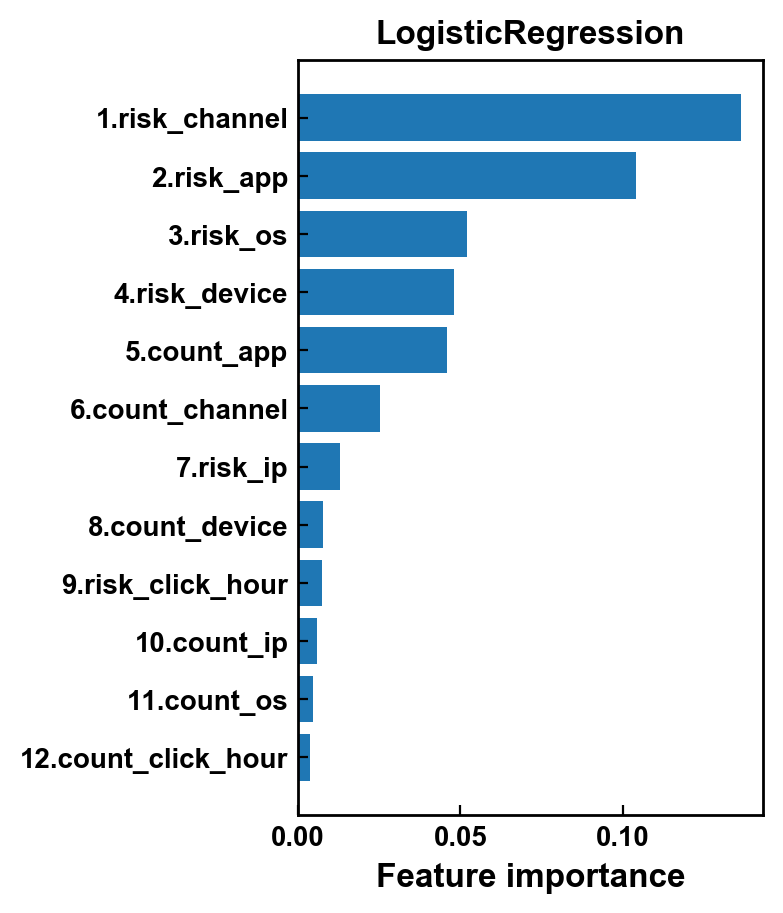

In [13]:
model_name = 'LogisticRegression'

# Use the best C value
estimator = LogisticRegression(class_weight='balanced', C=1e-6)
model = modeling.Classifier(gridsearch=False)
model.fit(estimator, X_train, y_train, cv=5)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test) 
test_score = roc_auc_score(y_test, y_pred)

# plot ROC curve
roc_val[model_name] = utils.plot_roc_curve(
    y_test, y_pred_proba, figsize=(4, 4), c='crimson', lw=3
)
# plot precision_vs_recall curve
prec_recall_val[model_name] = utils.plot_precision_vs_recall(
    y_test, y_pred_proba, figsize=(4, 4), c='darkblue', lw=3
)
# plot confusion matrix
confmat[model_name] = utils.plot_confusion_matrix(
    y_test, y_pred, figsize=(3, 3)
)

# Score keeping
df_scores = utils.ml_performance_summary(
    model.train_score, test_score, model_name=model_name
)
display(df_scores)

ft_importance[model_name] = utils.plot_feature_importance(
    model, feature_list=feature_cols, model_name=model_name, figsize=(3, 5)
);

randomforestclassifier
fit runtime = 23.11 s


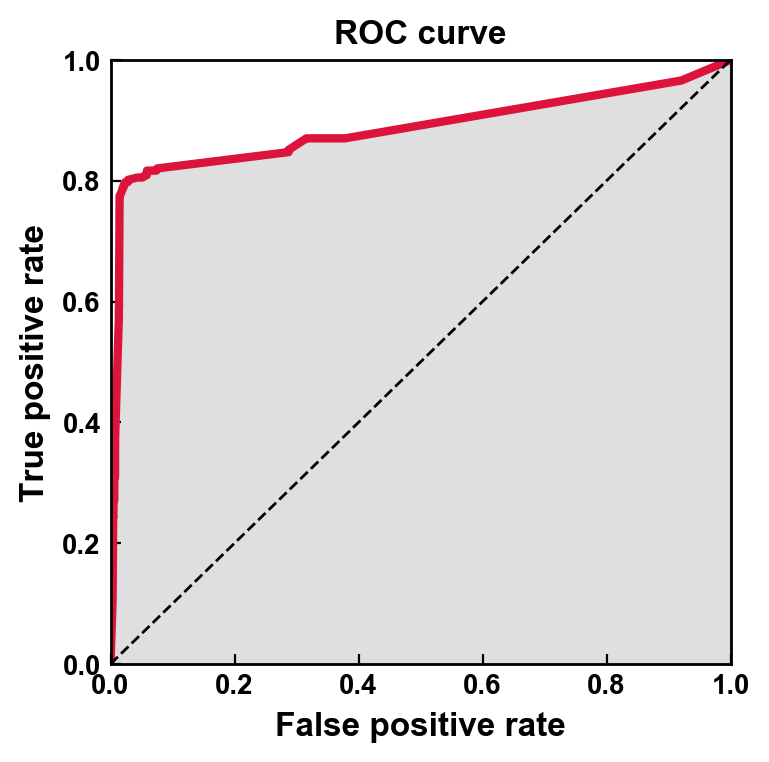

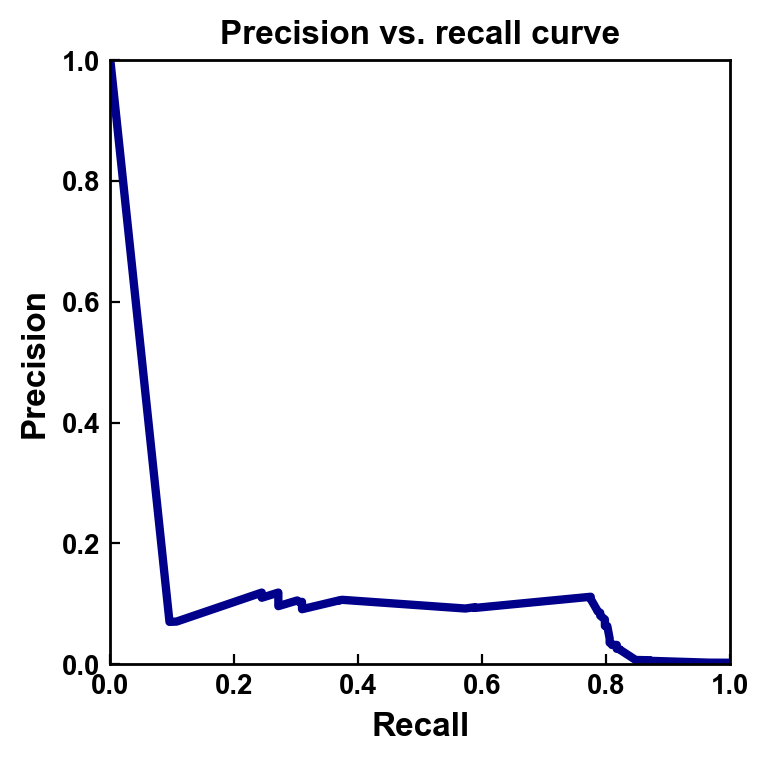

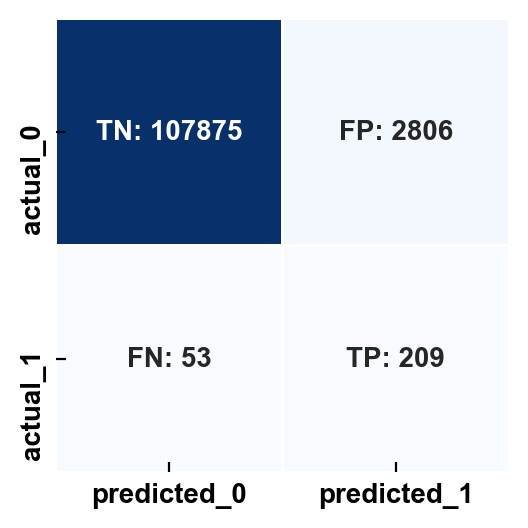

,model,auc_train,auc_cv_std,auc_test
0,LogisticRegression,0.945,0.015,0.878
1,RandomForest,0.928,0.024,0.886


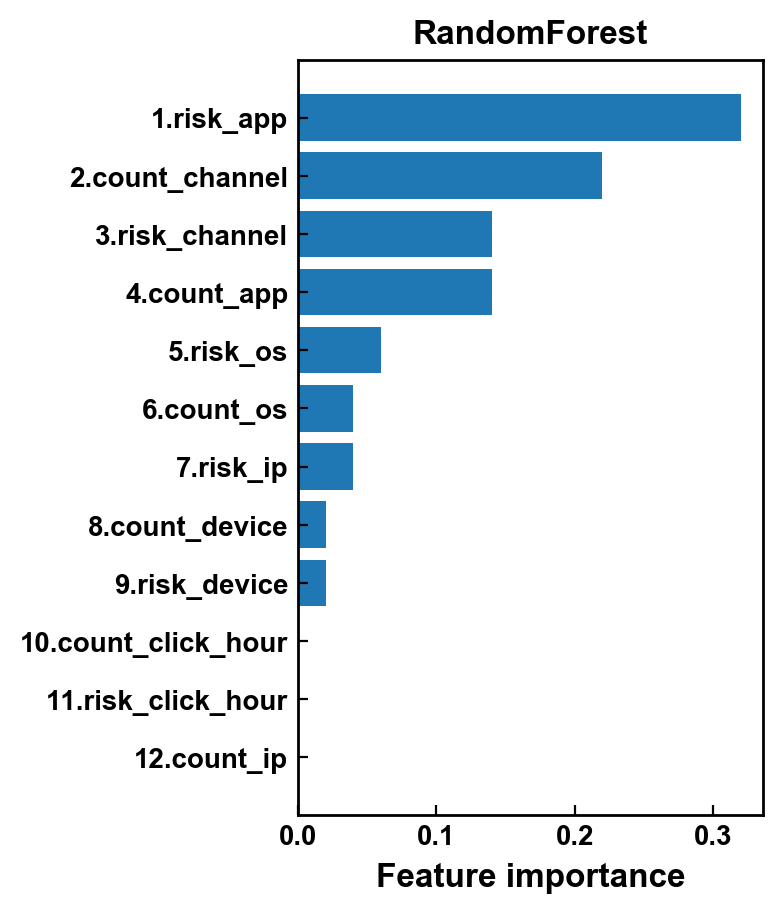

In [14]:
model_name = 'RandomForest'

# Use the best max_depth value
estimator = RandomForestClassifier(
    class_weight='balanced', max_depth=1, n_estimators=50,
    random_state=42
)
model = modeling.Classifier(gridsearch=False)
model.fit(estimator, X_train, y_train, cv=5)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
test_score = roc_auc_score(y_test, y_pred)

# ROC curve demo
roc_val[model_name] = utils.plot_roc_curve(
    y_test, y_pred_proba, figsize=(4, 4), c='crimson', lw=3
)
# plot precision_vs_recall curve
prec_recall_val[model_name] = utils.plot_precision_vs_recall(
    y_test, y_pred_proba, figsize=(4, 4), c='darkblue', lw=3
)
# plot confusion matrix
confmat[model_name] = utils.plot_confusion_matrix(
    y_test, y_pred, figsize=(3, 3)
)

# Score keeping
df_scores = df_scores.append(utils.ml_performance_summary(
    model.train_score, test_score, model_name=model_name
)).reset_index(drop=True)
display(df_scores)

ft_importance[model_name] = utils.plot_feature_importance(
    model, feature_list=feature_cols, model_name=model_name, figsize=(3, 5)
);

superlearner
fit runtime = 7.06 s
0.9157549169206598


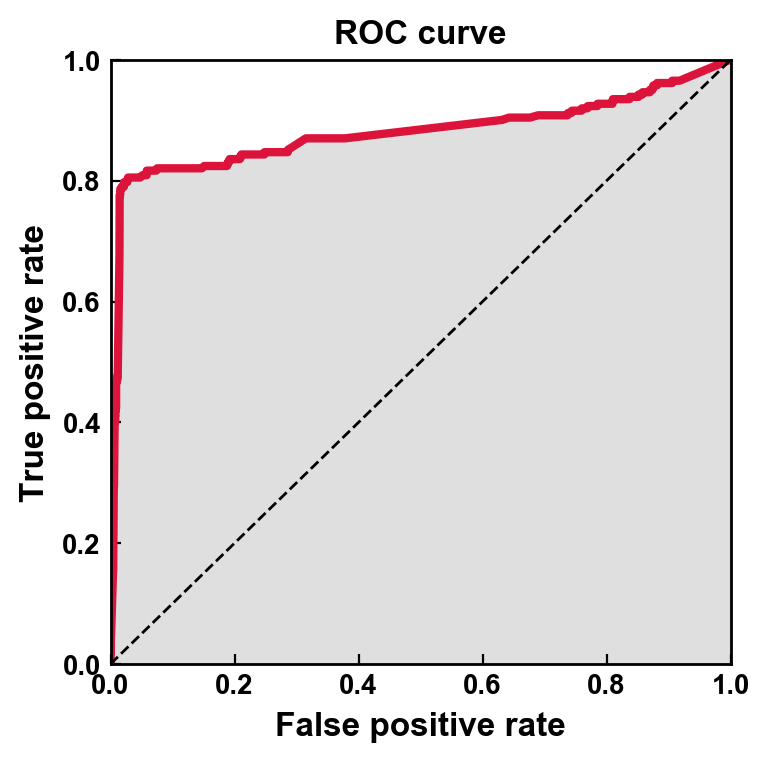

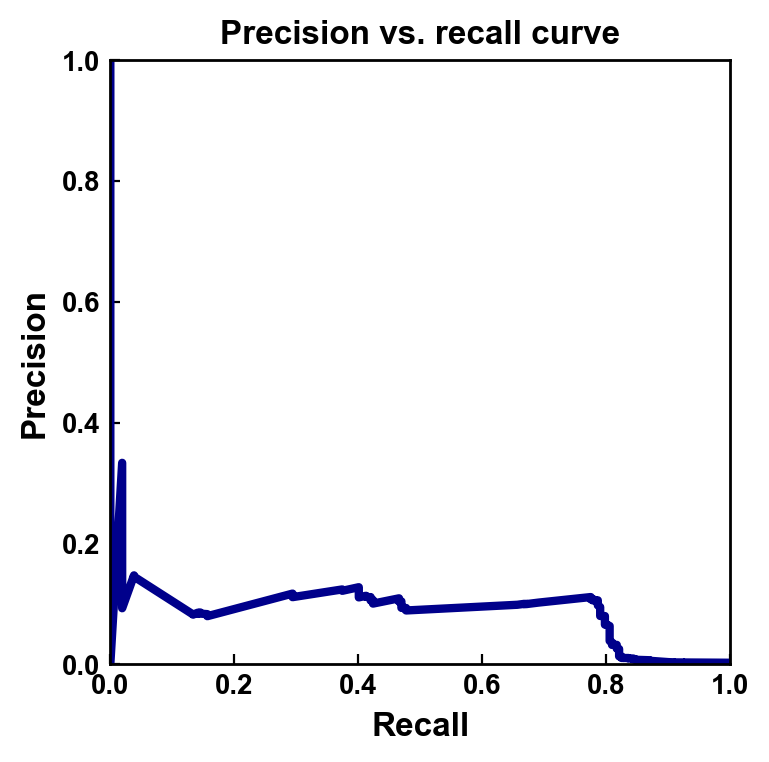

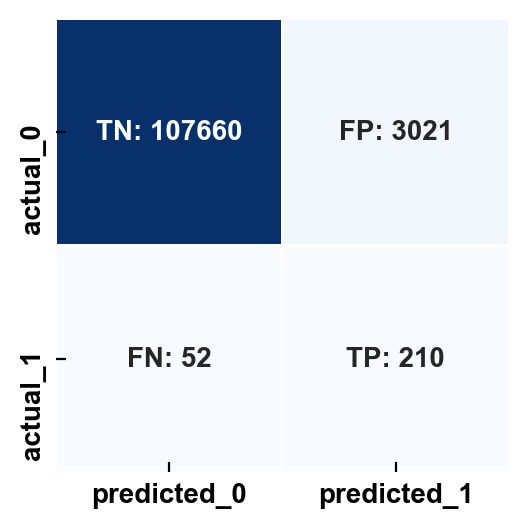

,model,auc_train,auc_cv_std,auc_test
0,LogisticRegression,0.945,0.015,0.878
1,RandomForest,0.928,0.024,0.886
2,StackEnsemble,0.916,nan,0.887


In [15]:
model_name = 'StackEnsemble'
estimator = SuperLearner(random_state=42, verbose=0)
import copy

def stacking_wrapper(estimator, proba=True):
    estimator.add([
        RandomForestClassifier(
            class_weight='balanced', max_depth=1, n_estimators=50,
            random_state=42
        ), GaussianNB()
    ], proba=proba);
    estimator.add_meta(
        LogisticRegression(class_weight='balanced'), proba=proba
    );
    
    model = modeling.Classifier(gridsearch=False)
    model.fit(estimator, X_train, y_train, cv=None)
    print(model.train_score)
    model_out = copy.deepcopy(model)
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba[:, 1] >= 0.5).astype(float)
    return (y_pred, y_pred_proba, model_out)
    

# y_pred = wrapper(estimator, proba=False)
y_pred, y_pred_proba, model = stacking_wrapper(estimator, proba=True)
test_score = roc_auc_score(y_test, y_pred)

# ROC curve demo
roc_val[model_name] = utils.plot_roc_curve(
    y_test, y_pred_proba, figsize=(4, 4), c='crimson', lw=3
)
# plot precision_vs_recall curve
prec_recall_val[model_name] = utils.plot_precision_vs_recall(
    y_test, y_pred_proba, figsize=(4, 4), c='darkblue', lw=3
)
# plot confusion matrix
confmat[model_name] = utils.plot_confusion_matrix(
    y_test, y_pred, figsize=(3, 3)
)

# Score keeping
df_scores = df_scores.append(utils.ml_performance_summary(
    model.train_score, test_score, model_name=model_name
)).reset_index(drop=True)
display(df_scores)

# ft_importance[model_name] = utils.plot_feature_importance(
#     model, feature_list=feature_cols, model_name=model_name, figsize=(3, 5)
# );

xgbclassifier
fit runtime = 28.20 s


/Users/shandou/anaconda3/envs/mlnd_clean/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


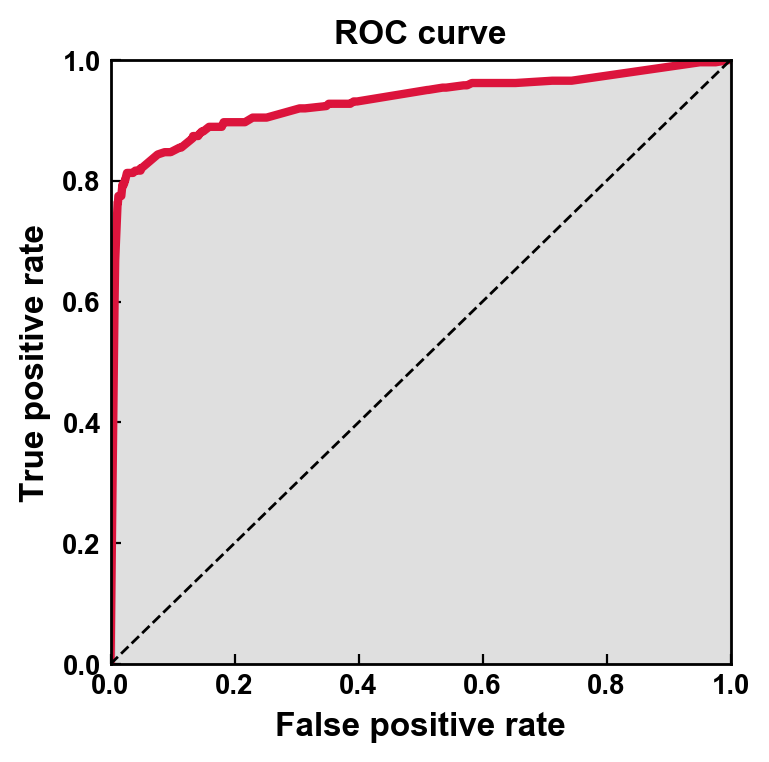

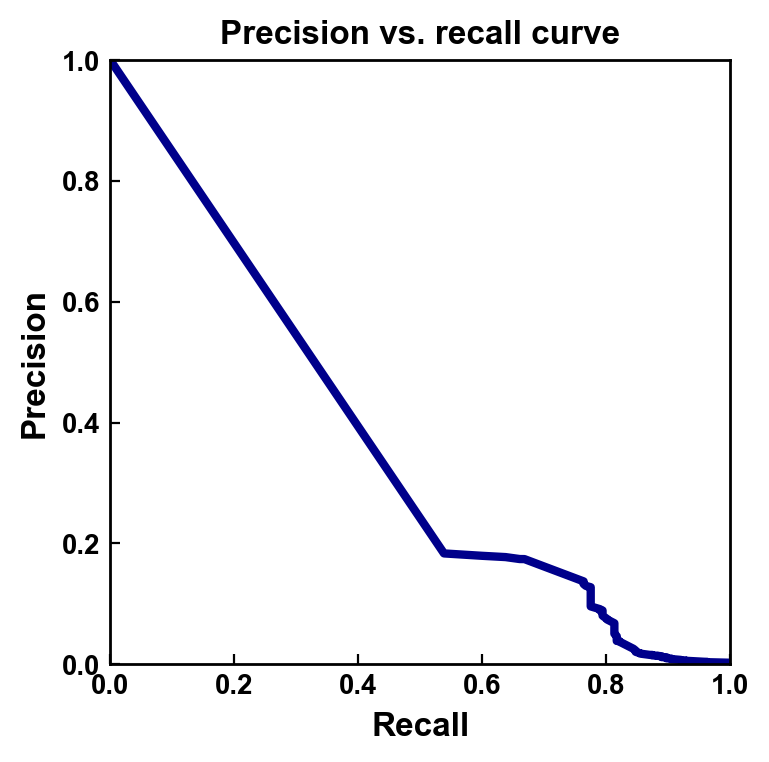

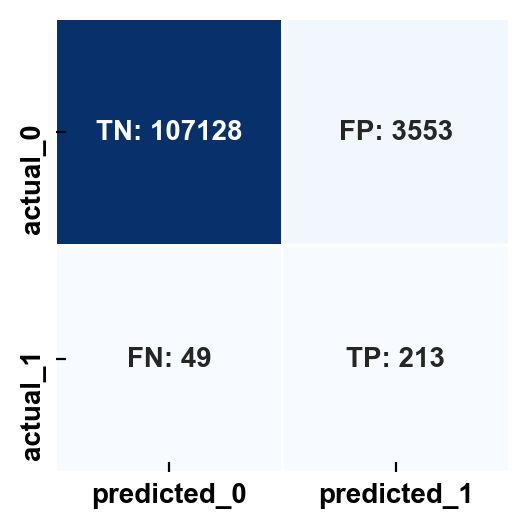

,model,auc_train,auc_cv_std,auc_test
0,LogisticRegression,0.945,0.015,0.878
1,RandomForest,0.928,0.024,0.886
2,StackEnsemble,0.916,nan,0.887
3,XGBoost,0.964,0.009,0.890


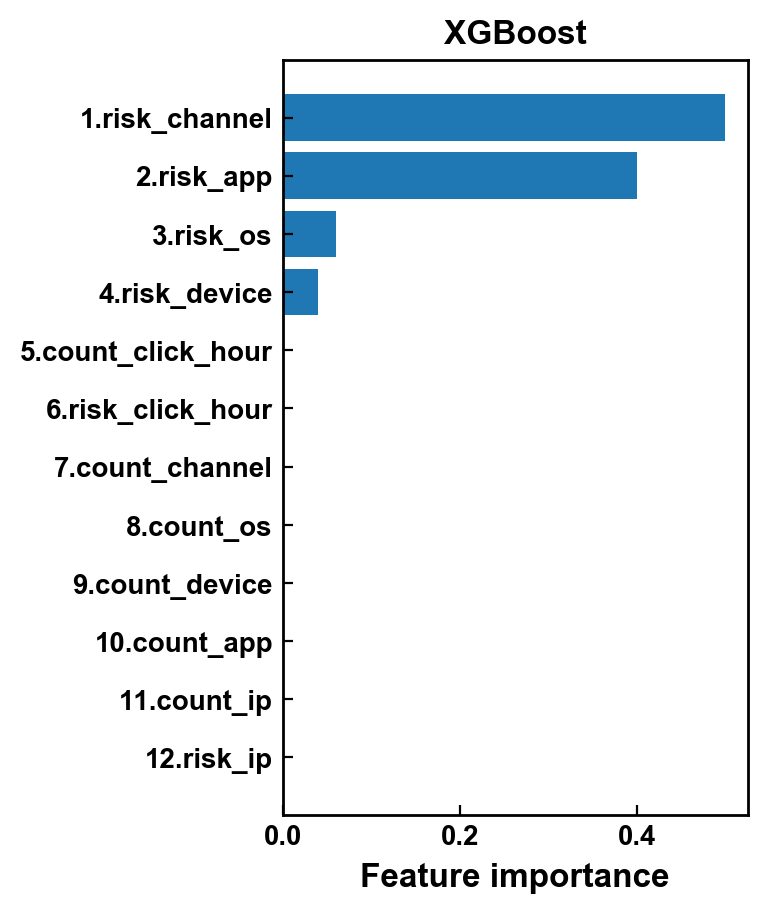

In [16]:
model_name = 'XGBoost'

# xgb scikit-learn API
estimator = xgb.XGBClassifier(
    max_depth=1, n_estimators=50, random_state=42
)
model = modeling.Classifier(gridsearch=False)
model.fit(estimator, X_train, y_train, cv=5)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
test_score = roc_auc_score(y_test, y_pred)

# ROC curve demo
roc_val[model_name] = utils.plot_roc_curve(
    y_test, y_pred_proba, figsize=(4, 4), c='crimson', lw=3
)
# plot precision_vs_recall curve
prec_recall_val[model_name] = utils.plot_precision_vs_recall(
    y_test, y_pred_proba, figsize=(4, 4), c='darkblue', lw=3
)
# plot confusion matrix
confmat[model_name] = utils.plot_confusion_matrix(
    y_test, y_pred, figsize=(3, 3)
)

# Score keeping
df_scores = df_scores.append(utils.ml_performance_summary(
    model.train_score, test_score, model_name=model_name
)).reset_index(drop=True)
display(df_scores)

ft_importance[model_name] = utils.plot_feature_importance(
    model, feature_list=feature_cols, model_name=model_name, figsize=(3, 5)
);

lgbmclassifier
fit runtime = 8.91 s


/Users/shandou/anaconda3/envs/mlnd_clean/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


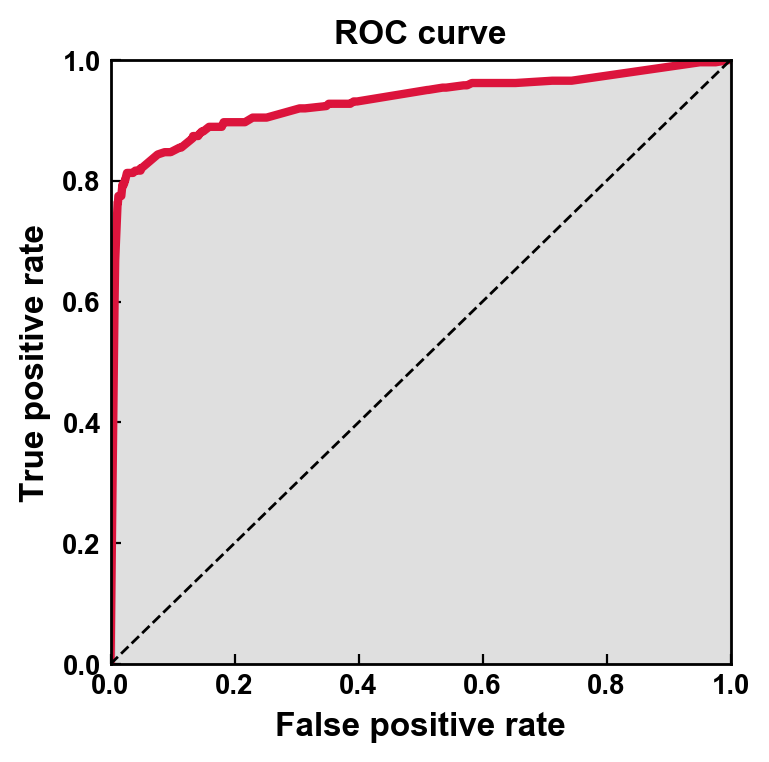

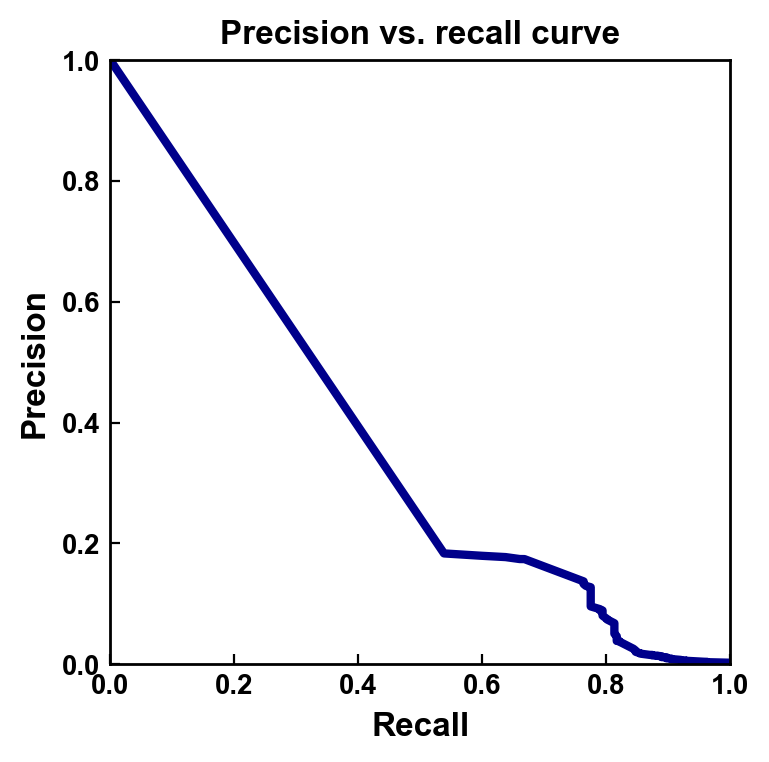

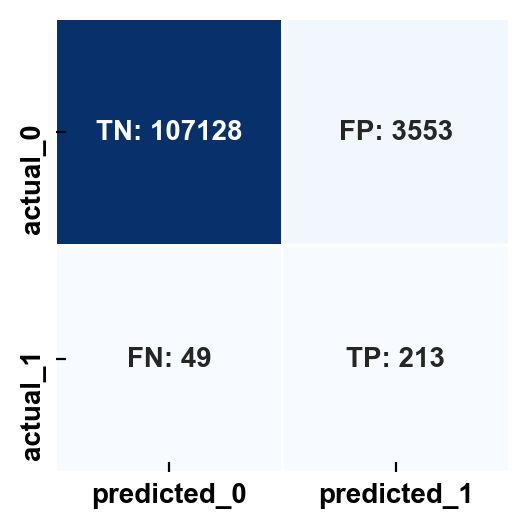

,model,auc_train,auc_cv_std,auc_test
0,LogisticRegression,0.945,0.015,0.878
1,RandomForest,0.928,0.024,0.886
2,StackEnsemble,0.916,nan,0.887
3,XGBoost,0.964,0.009,0.890
4,LightGBM,0.964,0.009,0.890


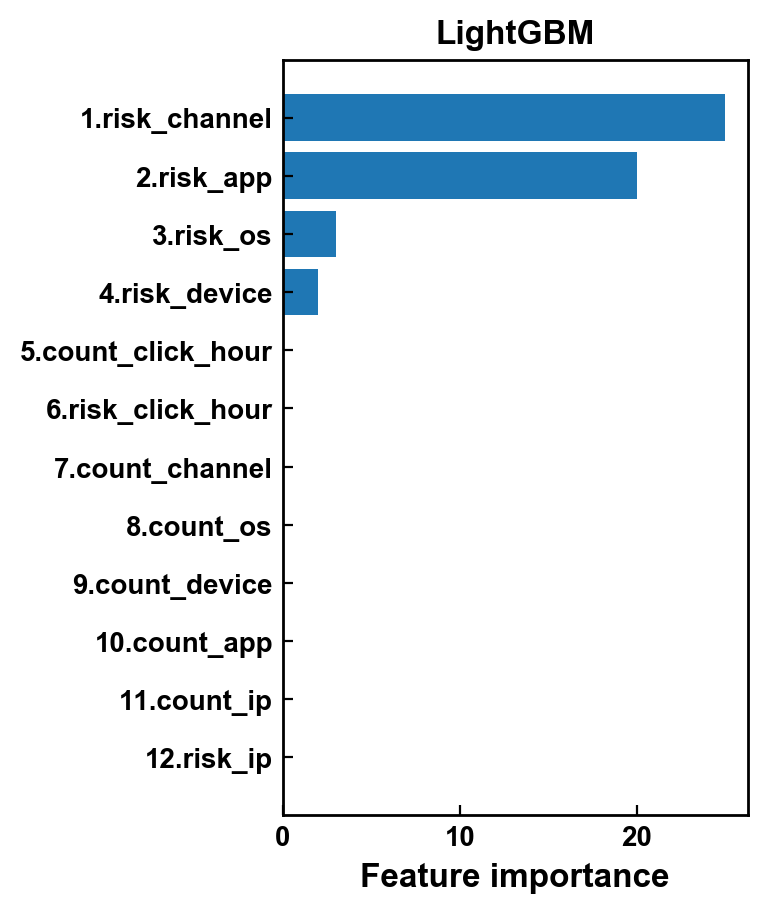

In [17]:
model_name = 'LightGBM'

# lightgbm scikit-learn API
estimator = lgb.LGBMClassifier(
    max_depth=1, n_estimators=50, random_state=42
)
model = modeling.Classifier(gridsearch=False)
model.fit(estimator, X_train, y_train, cv=5)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
test_score = roc_auc_score(y_test, y_pred)

# ROC curve demo
roc_val[model_name] = utils.plot_roc_curve(
    y_test, y_pred_proba, figsize=(4, 4), c='crimson', lw=3
)
# plot precision_vs_recall curve
prec_recall_val[model_name] = utils.plot_precision_vs_recall(
    y_test, y_pred_proba, figsize=(4, 4), c='darkblue', lw=3
)
# plot confusion matrix
confmat[model_name] = utils.plot_confusion_matrix(
    y_test, y_pred, figsize=(3, 3)
)

# Score keeping
df_scores = df_scores.append(utils.ml_performance_summary(
    model.train_score, test_score, model_name=model_name
)).reset_index(drop=True)
display(df_scores)


ft_importance[model_name] = utils.plot_feature_importance(
    model, feature_list=feature_cols, model_name=model_name, figsize=(3, 5)
);

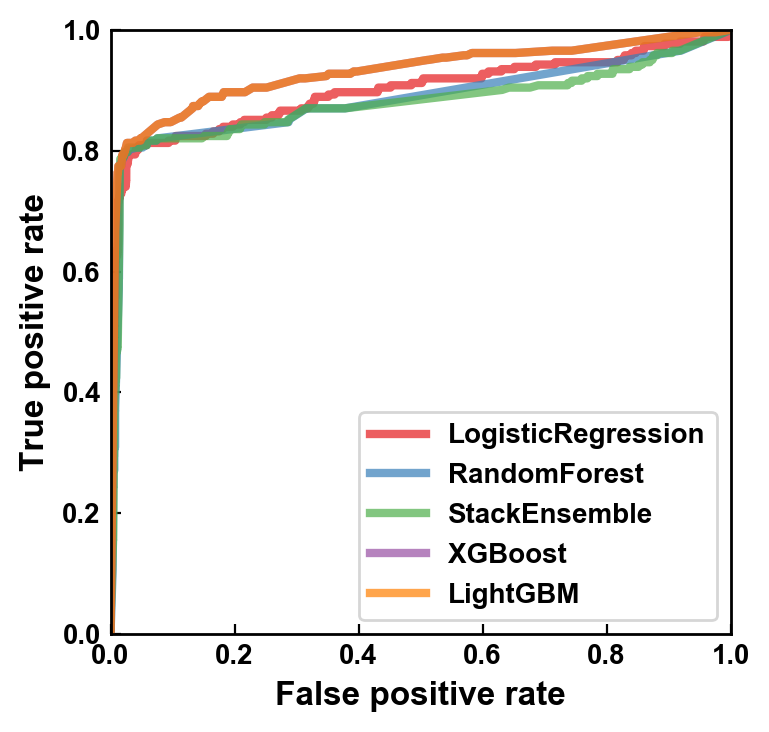

In [18]:
# ROC curve comparison
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_prop_cycle(cycler('color', linecolors))
for model in roc_val:
    ax.plot(
        roc_val[model][0], roc_val[model][1], lw=3, label=model, alpha=0.7
    )
ax.set(
    xlim=(0, 1), ylim=(0, 1),
    xlabel='False positive rate', ylabel='True positive rate'
)
ax.legend(loc='lower right')
plt.show();

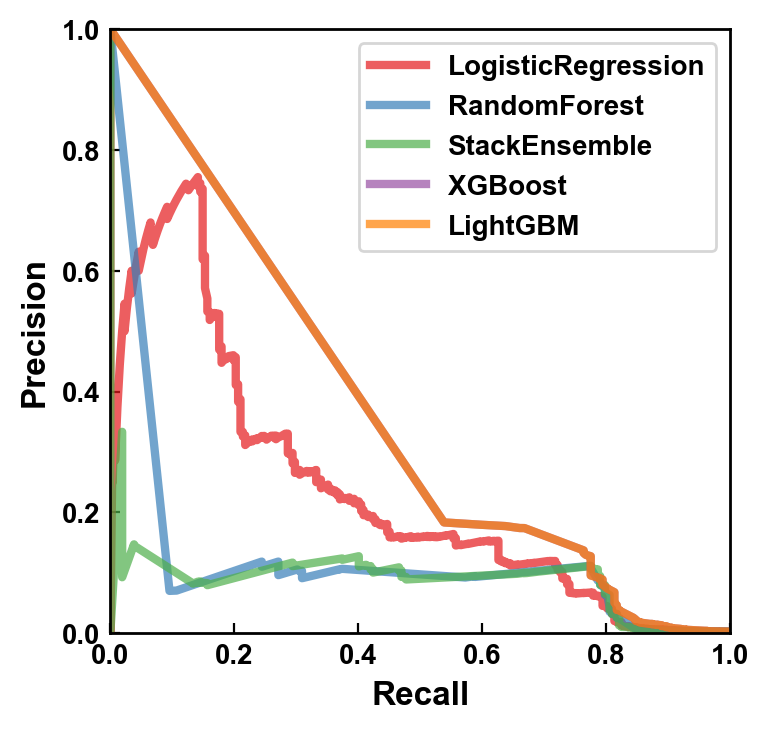

In [19]:
# Precision-recall curve comparison
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_prop_cycle(cycler('color', linecolors))
for model in roc_val:
    ax.plot(
        prec_recall_val[model][0], prec_recall_val[model][1], lw=3,
        label=model, alpha=0.7
    )
ax.set(
    xlim=(0, 1), ylim=(0, 1), xlabel='Recall', ylabel='Precision'
)
ax.legend(loc='upper right')
plt.show();

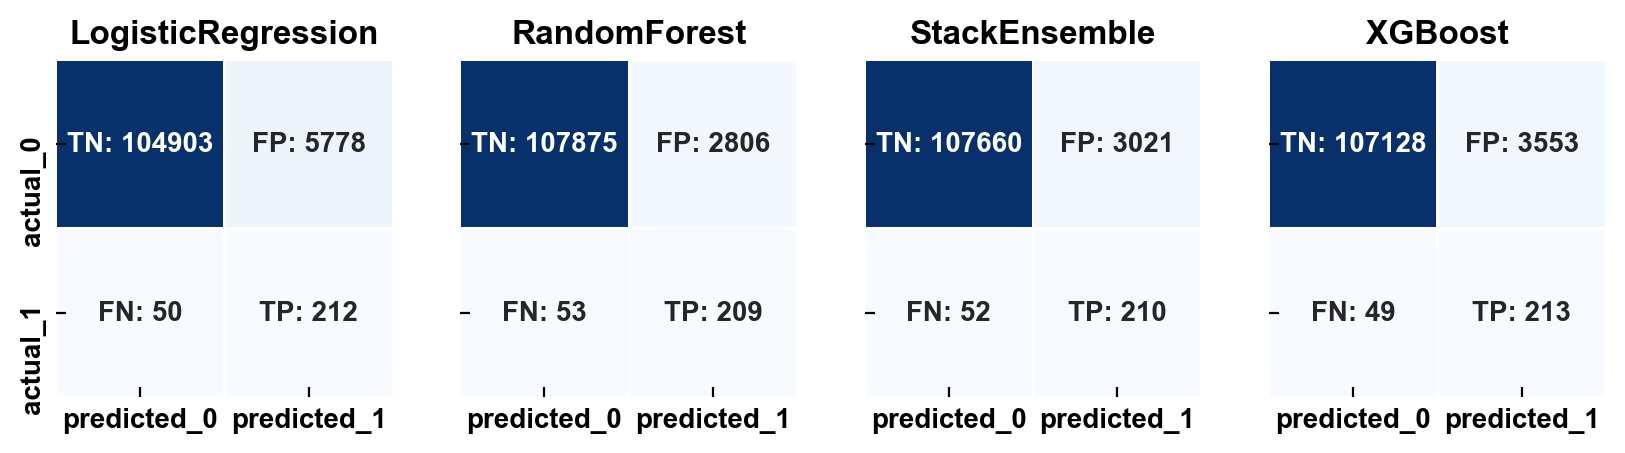

In [20]:
# Confusion matrix comparison
fig, ax = plt.subplots(
    nrows=1, ncols=4, figsize=(10, 3), sharex=True, sharey=True
)
for model, axi in zip(confmat, ax.flatten()):
    cm = confmat[model].values
    labels = np.array([
        ['TN: {:d}'.format(cm[0][0]), 'FP: {:d}'.format(cm[0][1])],
        ['FN: {:d}'.format(cm[1][0]), 'TP: {:d}'.format(cm[1][1])]
    ])
    sns.heatmap(
        confmat[model], annot=labels, cmap='Blues', square=True,
        linewidths=.5, cbar=False, fmt='', ax=axi
    )
    axi.set(title=model)
plt.show();

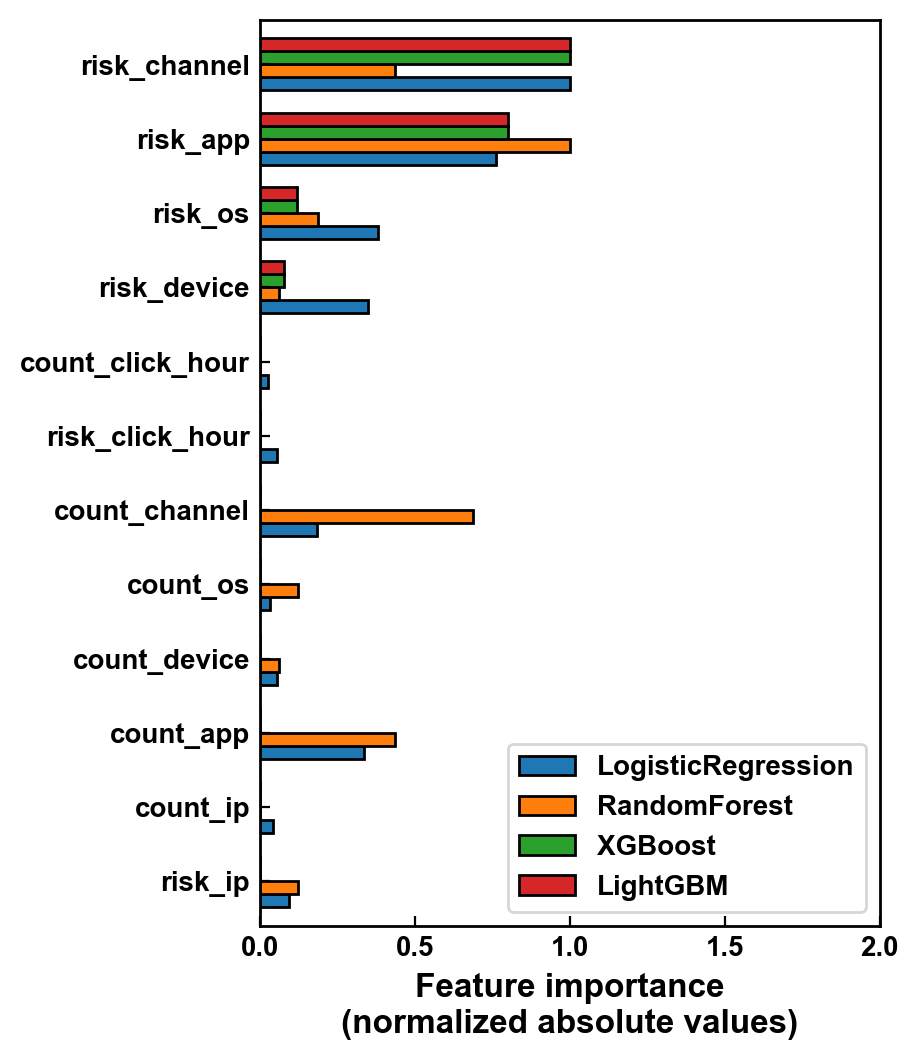

In [21]:
# Feature importance ranking comparison
model_list_ftimportance = [x for x in model_list if x is not 'StackEnsemble']
df_ft_importance = pd.DataFrame(
    index=ft_importance[model][0], columns=model_list_ftimportance
)
for model in model_list_ftimportance:
    df_ft_importance[model] = pd.DataFrame(
        index=ft_importance[model][0],
        data=abs(ft_importance[model][1])
    )
    df_ft_importance[model] = (
        df_ft_importance[model] / np.max(abs(df_ft_importance[model]))
    )

fig, ax = plt.subplots(figsize=(4, 6))
df_ft_importance.plot(kind='barh', ax=ax, width=0.7, edgecolor='k')
ax.set(xlim=(0, 2), xlabel='Feature importance\n(normalized absolute values)')
ax.legend(loc='lower right')
plt.show();

## Conclusion
---
When data size double, the advantage of light gradient boosting becomes clearer. It has the best shapes for both ROC curve and precision-recall curve, the best test core, and the training time only doubles as training data size doubles.